# NBA Player Prediction


In this project, we will use data from the 2017-2018 NBA season to predict the number of points a player scores. We will split our full dataset into training and testing sets. Then, we will perform exploratory analyses on the training set to help us gauge which features should be used in our model. We can then utilize machine learning principles to train a model that predicts the number of points per game a given player score.

Before beginning, it is important to note that we are not attempting to determine how valuable a player is to a team in the way that metrics such as win shares and value over replacement attempt to do. We are simply attempting to create a model that takes in a player's statistics and guesses how many points per game he will score.

## Importing Libraries

In [1]:
# Linear algebra
import numpy as np

# Data processing
import pandas as pd

# Data visualization
import seaborn as sns
sns.set()

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score as EVS, mean_squared_error as MSE

## Loading the Data

In [2]:
# Extra data on players 'https://raw.githubusercontent.com/evanpfeifer/nba-player-data/master/Players.csv'
# Extra data on players 'https://raw.githubusercontent.com/evanpfeifer/nba-player-data/master/player_data.csv'
url = 'https://raw.githubusercontent.com/evanpfeifer/nba-player-data/master/Seasons_Stats.csv'
df = pd.read_csv(url)

In [3]:
df.loc[df.Player=="James Harden"]

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
20133,20133,2010.0,James Harden,SG,20.0,OKC,76.0,0.0,1738.0,14.0,...,0.808,47.0,197.0,244.0,137.0,80.0,20.0,106.0,200.0,753.0
20766,20766,2011.0,James Harden,SG,21.0,OKC,82.0,5.0,2189.0,16.4,...,0.843,42.0,213.0,255.0,176.0,92.0,24.0,106.0,207.0,998.0
21338,21338,2012.0,James Harden,SG,22.0,OKC,62.0,2.0,1946.0,21.1,...,0.846,30.0,222.0,252.0,229.0,62.0,15.0,137.0,150.0,1044.0
21886,21886,2013.0,James Harden,SG,23.0,HOU,78.0,78.0,2985.0,23.0,...,0.851,62.0,317.0,379.0,455.0,142.0,38.0,295.0,178.0,2023.0
22504,22504,2014.0,James Harden,SG,24.0,HOU,73.0,73.0,2777.0,23.5,...,0.866,61.0,283.0,344.0,446.0,115.0,29.0,265.0,177.0,1851.0
23114,23114,2015.0,James Harden,SG,25.0,HOU,81.0,81.0,2981.0,26.7,...,0.868,75.0,384.0,459.0,565.0,154.0,60.0,321.0,208.0,2217.0
23722,23722,2016.0,James Harden,SG,26.0,HOU,82.0,82.0,3125.0,25.3,...,0.860,63.0,438.0,501.0,612.0,139.0,51.0,374.0,229.0,2376.0
24306,24306,2017.0,James Harden,PG,27.0,HOU,81.0,81.0,2947.0,27.3,...,0.847,95.0,564.0,659.0,906.0,120.0,37.0,464.0,215.0,2356.0


## Cleaning

In [4]:
# Filter for 2017/2018 season
df = df[df['Year'] == 2017]
df.head()


,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24096,24096,2017.0,Alex Abrines,SG,23.0,OKC,68.0,6.0,1055.0,10.1,...,0.898,18.0,68.0,86.0,40.0,37.0,8.0,33.0,114.0,406.0
24097,24097,2017.0,Quincy Acy,PF,26.0,TOT,38.0,1.0,558.0,11.8,...,0.750,20.0,95.0,115.0,18.0,14.0,15.0,21.0,67.0,222.0
24098,24098,2017.0,Quincy Acy,PF,26.0,DAL,6.0,0.0,48.0,-1.4,...,0.667,2.0,6.0,8.0,0.0,0.0,0.0,2.0,9.0,13.0
24099,24099,2017.0,Quincy Acy,PF,26.0,BRK,32.0,1.0,510.0,13.1,...,0.754,18.0,89.0,107.0,18.0,14.0,15.0,19.0,58.0,209.0
24100,24100,2017.0,Steven Adams,C,23.0,OKC,80.0,80.0,2389.0,16.5,...,0.611,282.0,333.0,615.0,86.0,88.0,78.0,146.0,195.0,905.0


Here we can see that a player can span multiple rows if they played for more than one team during the season. We are going to disregard the team(s) that any given player played for so that we have one row per player during the season. Whenever a player played for more than one team, they have a row with team name "TOT" that gives their overall statistics across all teams they played for.

In [5]:
df.loc[df.Player == 'Ersan Ilyasova']

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24354,24354,2017.0,Ersan Ilyasova,PF,29.0,TOT,82.0,52.0,2142.0,14.6,...,0.778,115.0,366.0,481.0,141.0,58.0,23.0,116.0,211.0,1071.0
24355,24355,2017.0,Ersan Ilyasova,PF,29.0,OKC,3.0,0.0,62.0,6.9,...,NaN,2.0,14.0,16.0,1.0,3.0,1.0,4.0,5.0,15.0
24356,24356,2017.0,Ersan Ilyasova,PF,29.0,PHI,53.0,40.0,1447.0,15.4,...,0.768,71.0,243.0,314.0,97.0,33.0,14.0,78.0,133.0,786.0
24357,24357,2017.0,Ersan Ilyasova,PF,29.0,ATL,26.0,12.0,633.0,13.5,...,0.800,42.0,109.0,151.0,43.0,22.0,8.0,34.0,73.0,270.0


In [6]:
# Include only "TOT" for players who played for multiple teams
tot_df = df.loc[df.Tm=='TOT']
players2 = tot_df['Player']
df.drop(tot_df.index + 1, axis=0, inplace=True)
df.drop(tot_df.index + 2, axis=0, inplace=True)
df.drop(24357, axis=0, inplace=True)
df.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24096,24096,2017.0,Alex Abrines,SG,23.0,OKC,68.0,6.0,1055.0,10.1,...,0.898,18.0,68.0,86.0,40.0,37.0,8.0,33.0,114.0,406.0
24097,24097,2017.0,Quincy Acy,PF,26.0,TOT,38.0,1.0,558.0,11.8,...,0.750,20.0,95.0,115.0,18.0,14.0,15.0,21.0,67.0,222.0
24100,24100,2017.0,Steven Adams,C,23.0,OKC,80.0,80.0,2389.0,16.5,...,0.611,282.0,333.0,615.0,86.0,88.0,78.0,146.0,195.0,905.0
24101,24101,2017.0,Arron Afflalo,SG,31.0,SAC,61.0,45.0,1580.0,9.0,...,0.892,9.0,116.0,125.0,78.0,21.0,7.0,42.0,104.0,515.0
24102,24102,2017.0,Alexis Ajinca,C,28.0,NOP,39.0,15.0,584.0,12.9,...,0.725,46.0,131.0,177.0,12.0,20.0,22.0,31.0,77.0,207.0


We'll first select some initial features, likely more than will be used in the final model in order to give us some wiggle room. We have not included many metrics that attempt to quanitify a player's overall value to the team, such as value over replacement (VORP) or win shares, as these are quite unlikely to provide much about whether a player will score many points. Likewise, we have left out some defense focussed features.

All features we selected:
* Pos: position
* Age: player age
* Tm: team
* G: games
* MP: minutes played per game
* PER: player efficiency rating
* TS%: true shooting %
* TRB%: total rebound %
* STL%: steal %
* TOV%: turnover %
* FGA: field goal attempts per game
* 3P: 3-point field goals
* 3P%: 3-point field goal percentage
* 2P: 2-point field goals
* 2P%: 2-point field goal percentage
* eFG%: effective field goal percentage
* PTS: points per game


In [7]:

features = ['Player', 'Pos', 'Age', 'G', 'MP', 'PER', 'TS%', 'TRB%', 'STL%', 'TOV%', 'FGA', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'PTS']

df = df[features]

# Change minutes played, FG attempts, and points to be per game
df['MP'] = df['MP'] / df['G']
df['FGA'] = df['FGA'] / df['G']
df['PTS'] = df['PTS'] / df['G']

df.head()

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24096,Alex Abrines,SG,23.0,68.0,15.514706,10.1,0.560,4.5,1.7,8.3,5.014706,94.0,247.0,0.381,40.0,94.0,0.426,0.531,5.970588
24097,Quincy Acy,PF,26.0,38.0,14.684211,11.8,0.565,11.0,1.2,9.7,4.473684,37.0,90.0,0.411,33.0,80.0,0.413,0.521,5.842105
24100,Steven Adams,C,23.0,80.0,29.862500,16.5,0.589,14.2,1.8,16.0,8.187500,0.0,1.0,0.000,374.0,654.0,0.572,0.571,11.312500
24101,Arron Afflalo,SG,31.0,61.0,25.901639,9.0,0.559,4.6,0.7,8.4,6.885246,62.0,151.0,0.411,123.0,269.0,0.457,0.514,8.442623
24102,Alexis Ajinca,C,28.0,39.0,14.974359,12.9,0.529,16.0,1.7,13.7,4.564103,0.0,4.0,0.000,89.0,174.0,0.511,0.500,5.307692


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 24096 to 24690
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  488 non-null    object 
 1   Pos     488 non-null    object 
 2   Age     488 non-null    float64
 3   G       488 non-null    float64
 4   MP      488 non-null    float64
 5   PER     488 non-null    float64
 6   TS%     487 non-null    float64
 7   TRB%    488 non-null    float64
 8   STL%    488 non-null    float64
 9   TOV%    487 non-null    float64
 10  FGA     488 non-null    float64
 11  3P      488 non-null    float64
 12  3PA     488 non-null    float64
 13  3P%     452 non-null    float64
 14  2P      488 non-null    float64
 15  2PA     488 non-null    float64
 16  2P%     486 non-null    float64
 17  eFG%    487 non-null    float64
 18  PTS     488 non-null    float64
dtypes: float64(17), object(2)
memory usage: 76.2+ KB


Note that there are some missing values for 2 and 3-point percentages, despite no missing values for 2 and 3-point attempts or baskets made. After some snooping, it can be discovered that these NaN values are a result of a division by zero error. Since 2 and 3-point percentages are calculated by dividing attempts made by total attempts, if a player made no 3 point attempts, the resulting 3-point percentage is NaN. We don't want to simply drop all players that didn't make any 3-point attempts, because players like Boban Marjanovic (who took no 3-point attempts that season) are inarguably important for a team's scoring. To get around this, we can simply find which players had no 3-point attempts and give them 3-point percentage values of 0.

In [9]:
df.loc[df['3PA'] == 0, '3P%'] = 0
df.loc[df['2PA'] == 0, '2P%'] = 0

In [10]:
df[df.isna().any(axis=1)]

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24344,Danuel House,SG,23.0,1.0,1.0,12.2,NaN,56.4,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


Quite remarkably, we now only have one player with missing data. Given the fact that Danuel House had barely any play time with no points, it's okay to drop him entirely from the dataset.

In [11]:
df.drop([24344], inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 24096 to 24690
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  487 non-null    object 
 1   Pos     487 non-null    object 
 2   Age     487 non-null    float64
 3   G       487 non-null    float64
 4   MP      487 non-null    float64
 5   PER     487 non-null    float64
 6   TS%     487 non-null    float64
 7   TRB%    487 non-null    float64
 8   STL%    487 non-null    float64
 9   TOV%    487 non-null    float64
 10  FGA     487 non-null    float64
 11  3P      487 non-null    float64
 12  3PA     487 non-null    float64
 13  3P%     487 non-null    float64
 14  2P      487 non-null    float64
 15  2PA     487 non-null    float64
 16  2P%     487 non-null    float64
 17  eFG%    487 non-null    float64
 18  PTS     487 non-null    float64
dtypes: float64(17), object(2)
memory usage: 76.1+ KB


## Train/Test Splitting

We will be employing cross-validation in order to tune hyperparameters in our models, thus eliminating the need for a separate validation set.

As is common practice, we will use 80% of our data for training and the final 20% for testing. In order to manually obtain train and test sets, we'll shuffle the rows by sampling radomply without replacement, then take the first 390 (60%) players to form out training set, and the remaining 97 will form the test set.

In [13]:
shuffled = df.sample(frac=1, replace=False, random_state=1)
train_df = shuffled.iloc[np.arange(390)]
test_df = shuffled.iloc[np.arange(390, 487)]

In [14]:
train_df.head()

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24275,Rudy Gay,SF,30.0,30.0,33.766667,17.9,0.559,10.8,2.2,12.8,14.733333,42.0,113.0,0.372,159.0,329.0,0.483,0.502,18.733333
24265,Randy Foye,SG,33.0,69.0,18.608696,7.3,0.506,6.4,1.3,18.5,4.710145,67.0,203.0,0.330,51.0,122.0,0.418,0.466,5.173913
24298,Draymond Green,PF,26.0,76.0,32.513158,16.5,0.522,13.3,3.0,19.8,8.552632,81.0,263.0,0.308,191.0,387.0,0.494,0.481,10.210526
24592,Tony Snell,SG,25.0,80.0,29.200000,9.7,0.603,6.2,1.2,8.8,6.762500,144.0,355.0,0.406,102.0,186.0,0.548,0.588,8.537500
24341,Richaun Holmes,C,23.0,57.0,20.929825,18.6,0.611,14.4,1.7,10.7,7.228070,27.0,77.0,0.351,203.0,335.0,0.606,0.591,9.807018


In [15]:
# Top ten players by PPG
train_df.sort_values(by=['PTS'], ascending=False).head(10)

,Player,Pos,Age,G,MP,PER,TS%,TRB%,STL%,TOV%,FGA,3P,3PA,3P%,2P,2PA,2P%,eFG%,PTS
24654,Russell Westbrook,PG,28.0,81.0,34.592593,30.6,0.554,17.1,2.3,15.9,23.962963,200.0,583.0,0.343,624.0,1358.0,0.459,0.476,31.580247
24306,James Harden,PG,27.0,81.0,36.382716,27.3,0.613,12.2,2.0,19.5,18.925926,262.0,756.0,0.347,412.0,777.0,0.530,0.525,29.086420
24612,Isaiah Thomas,PG,27.0,76.0,33.802632,26.5,0.625,4.4,1.4,10.7,19.381579,245.0,646.0,0.379,437.0,827.0,0.528,0.546,28.934211
24218,Anthony Davis,C,23.0,75.0,36.106667,27.5,0.579,17.3,1.7,9.1,20.360000,40.0,134.0,0.299,730.0,1393.0,0.524,0.517,27.986667
24226,DeMar DeRozan,SG,27.0,74.0,35.405405,24.0,0.552,8.3,1.5,9.0,20.878378,33.0,124.0,0.266,688.0,1421.0,0.484,0.477,27.297297
24206,DeMarcus Cousins,C,26.0,72.0,34.236111,25.7,0.562,18.2,2.0,13.5,19.902778,131.0,364.0,0.360,516.0,1069.0,0.483,0.497,26.972222
24365,LeBron James,SF,32.0,74.0,37.756757,27.0,0.619,12.6,1.6,16.1,18.162162,124.0,342.0,0.363,612.0,1002.0,0.611,0.594,26.405405
24414,Kawhi Leonard,SF,25.0,74.0,33.432432,27.5,0.611,9.8,2.7,9.1,17.716216,147.0,386.0,0.381,489.0,925.0,0.529,0.541,25.513514
24216,Stephen Curry,PG,28.0,79.0,33.392405,24.6,0.624,7.3,2.6,13.0,18.265823,324.0,789.0,0.411,351.0,654.0,0.537,0.580,25.303797
24360,Kyrie Irving,PG,24.0,72.0,35.069444,23.0,0.580,5.0,1.6,10.3,19.722222,177.0,441.0,0.401,494.0,979.0,0.505,0.535,25.222222


In [68]:
# Average PPG among all players
ppg_all = np.average(train_df['PTS'])

# Average PPG for those who had more than 5 PPG
ppg_plus5 = np.average(train_df[train_df.PTS > 5].PTS)

print('Average PPG among all players: ', ppg_all)
print('Average PPG for those who had more than 5 PPG: ', ppg_plus5)

Average PPG among all players:  8.58896397704793
Average PPG for those who had more than 5 PPG:  11.35300158956498


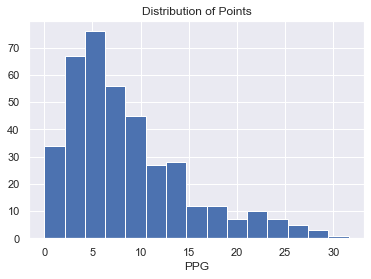

In [16]:
# Distribution of points
plt.hist(train_df['PTS'], bins=15)
plt.title('Distribution of Points')
plt.xlabel('PPG')
plt.show()

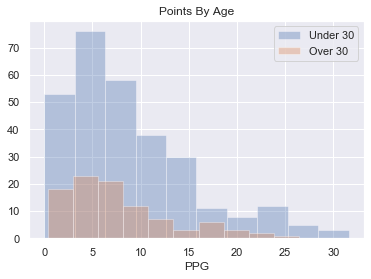

In [17]:
# Comparing PPG for players over & under 30
under_30 = train_df.loc[train_df.Age < 30].PTS
over_30 = train_df.loc[train_df.Age >= 30].PTS

plt.hist(x=under_30, alpha=0.35, label='Under 30')
plt.hist(x=over_30, alpha=0.35, label='Over 30')
plt.legend()
plt.xlabel('PPG')
plt.title('Points By Age')
plt.show() 

Since the PTS distribution for players under 30 and over 30 follow the same pattern there no need to examine them differently

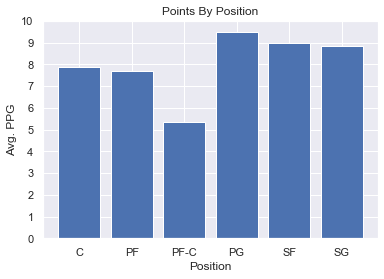

In [18]:
# Average points by position 
grouped_position = train_df[['Pos', 'PTS']].groupby(by=['Pos']).mean()

plt.bar(grouped_position.index, height=grouped_position.PTS)
plt.xlabel('Position')
plt.ylabel('Avg. PPG')
plt.title('Points By Position')
plt.yticks(np.arange(0, 11))
plt.show()

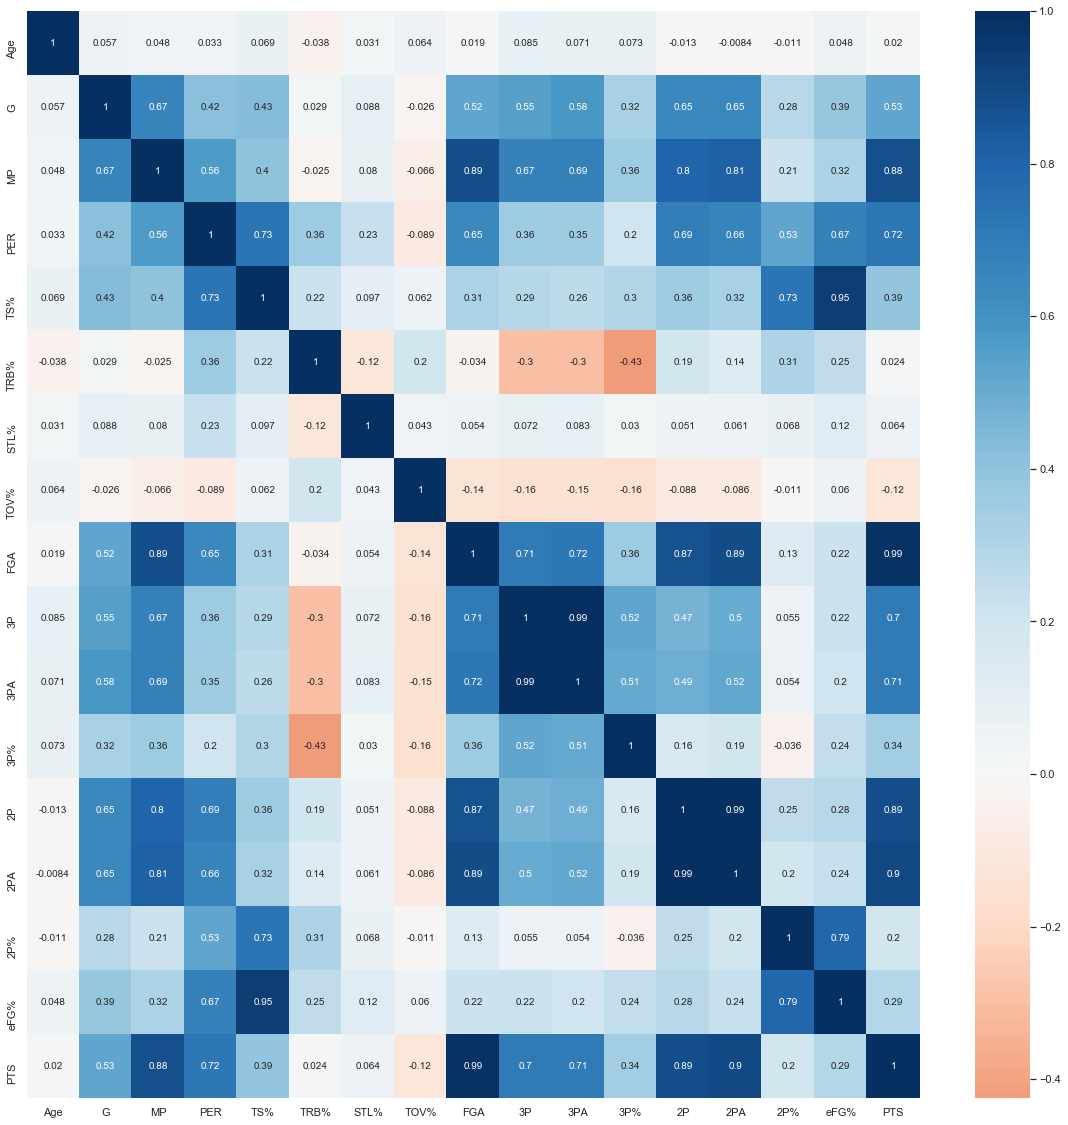

In [19]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot=True, center=0, cmap="RdBu")
plt.show()

R-squared: 0.7667192657378217


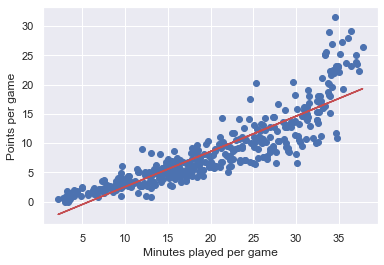

In [20]:



# scatter plots of points per game against minutes played per game
plt.scatter(train_df["MP"],train_df["PTS"])
plt.xlabel("Minutes played per game")
plt.ylabel("Points per game")
Linear_model = LinearRegression()
Linear_model.fit(train_df[["MP"]], train_df[["PTS"]])
mp_predict = Linear_model.predict(train_df[["MP"]])
plt.plot(train_df["MP"], mp_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["MP"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.5179211452749585


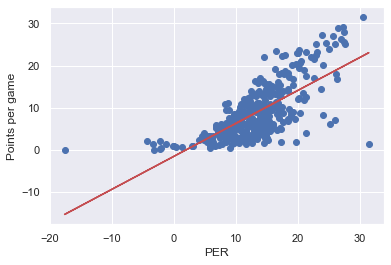

In [21]:
# scatter plots of points per game against PER
plt.scatter(train_df["PER"], train_df["PTS"])
plt.xlabel("PER")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["PER"]], train_df[["PTS"]])
per_predict = Linear_model.predict(train_df[["PER"]])
plt.plot(train_df["PER"], per_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["PER"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.15565307811049378


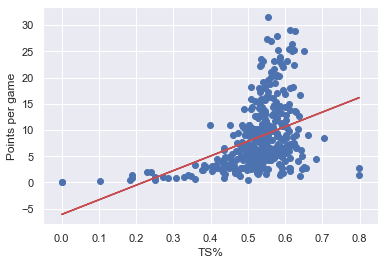

In [22]:

# scatter plots of points per game against TS%
plt.scatter(train_df["TS%"], train_df["PTS"])
plt.xlabel("TS%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["TS%"]], train_df[["PTS"]])
ts_predict = Linear_model.predict(train_df[["TS%"]])
plt.plot(train_df["TS%"], ts_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["TS%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.0005915311575651616


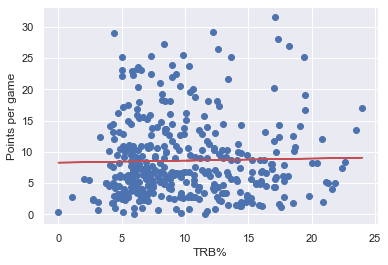

In [23]:
# scatter plots of points per game against TRB%
plt.scatter(train_df["TRB%"], train_df["PTS"])
plt.xlabel("TRB%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["TRB%"]], train_df[["PTS"]])
trb_predict = Linear_model.predict(train_df[["TRB%"]])
plt.plot(train_df["TRB%"], trb_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["TRB%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.004062778429081426


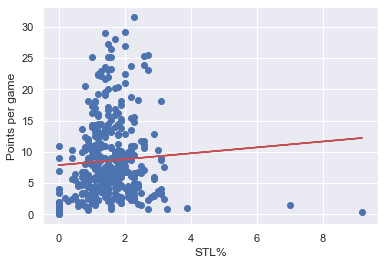

In [24]:
# scatter plots of points per game against STL%
plt.scatter(train_df["STL%"], train_df["PTS"])
plt.xlabel("STL%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["STL%"]], train_df[["PTS"]])
stl_predict = Linear_model.predict(train_df[["STL%"]])
plt.plot(train_df["STL%"], stl_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["STL%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.015061990476007536


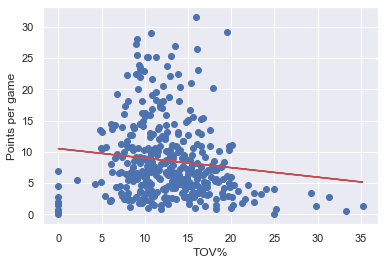

In [25]:
# scatter plots of points per game against TOV%
plt.scatter(train_df["TOV%"], train_df["PTS"])
plt.xlabel("TOV%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["TOV%"]], train_df[["PTS"]])
tov_predict = Linear_model.predict(train_df[["TOV%"]])
plt.plot(train_df["TOV%"], tov_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["TOV%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.9706213056177363


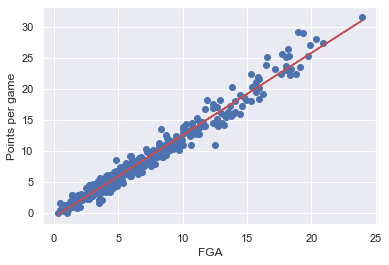

In [26]:

# scatter plots of points per game against FGA
plt.scatter(train_df["FGA"], train_df["PTS"])
plt.xlabel("FGA")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["FGA"]], train_df[["PTS"]])
fga_predict = Linear_model.predict(train_df[["FGA"]])
plt.plot(train_df["FGA"], fga_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["FGA"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.11897836939624407


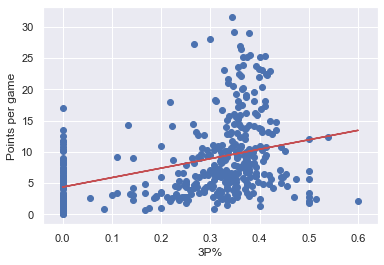

In [27]:
# scatter plots of points per game against 3P%
plt.scatter(train_df["3P%"], train_df["PTS"])
plt.xlabel("3P%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["3P%"]], train_df[["PTS"]])
threep_predict = Linear_model.predict(train_df[["3P%"]])
plt.plot(train_df["3P%"], threep_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["3P%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.038932805457997044


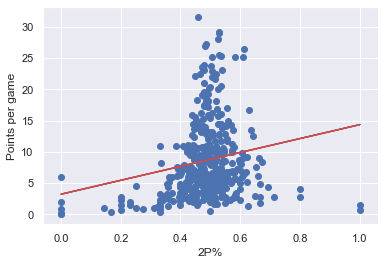

In [28]:
# scatter plots of points per game against 2P%
plt.scatter(train_df["2P%"], train_df["PTS"])
plt.xlabel("2P%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["2P%"]], train_df[["PTS"]])
twop_predict = Linear_model.predict(train_df[["2P%"]])
plt.plot(train_df["2P%"], twop_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2P%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.08354007281772402


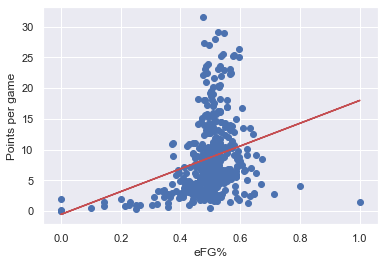

In [29]:
# scatter plots of points per game against eFG%
plt.scatter(train_df["eFG%"], train_df["PTS"])
plt.xlabel("eFG%")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["eFG%"]], train_df[["PTS"]])
efg_predict = Linear_model.predict(train_df[["eFG%"]])
plt.plot(train_df["eFG%"], efg_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["eFG%"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.5042844231517124


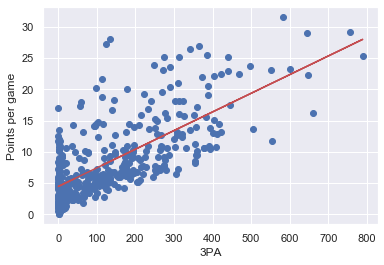

In [30]:
# scatter plots of points per game against 3PA
plt.scatter(train_df["3PA"], train_df["PTS"])
plt.xlabel("3PA")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["3PA"]], train_df[["PTS"]])
TPA_predict = Linear_model.predict(train_df[["3PA"]])
plt.plot(train_df["3PA"], TPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["3PA"]], train_df[["PTS"]])) # R-squared value

R-squared: 0.8020962690292562


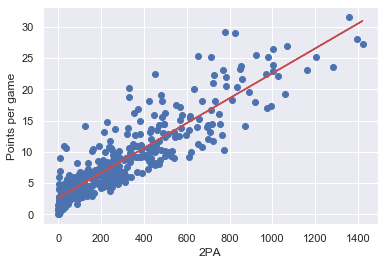

In [31]:
# scatter plots of points per game against 3PA
plt.scatter(train_df["2PA"], train_df["PTS"])
plt.xlabel("2PA")
plt.ylabel("Points per game")
Linear_model.fit(train_df[["2PA"]], train_df[["PTS"]])
TWPA_predict = Linear_model.predict(train_df[["2PA"]])
plt.plot(train_df["2PA"], TWPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2PA"]], train_df[["PTS"]]))

R-squared: 0.26998194181002133
VIF value: 1.3698291278977672


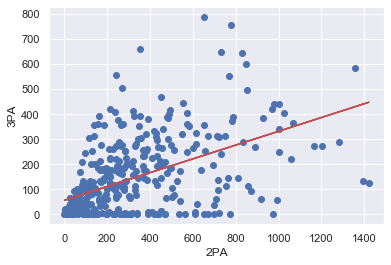

In [32]:
# scatter plots of 2PA against 3PA
plt.scatter(train_df["2PA"], train_df["3PA"])
plt.xlabel("2PA")
plt.ylabel("3PA")
Linear_model.fit(train_df[["2PA"]], train_df[["3PA"]])
TWTPA_predict = Linear_model.predict(train_df[["2PA"]])
plt.plot(train_df["2PA"], TWTPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2PA"]], train_df[["3PA"]]))
print("VIF value:", 1/(1-Linear_model.score(train_df[["2PA"]], train_df[["3PA"]]))) #check for collinearity of the variables since it's smaller than 4 there is no problem 

R-squared: 0.7959510797304998
VIF value: 4.900785550245684


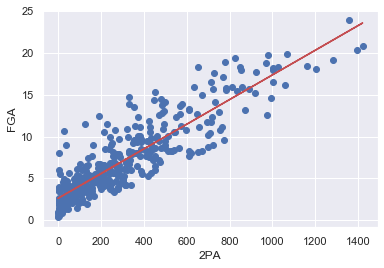

In [33]:
# scatter plots of 2PA against FGA
plt.scatter(train_df["2PA"], train_df["FGA"])
plt.xlabel("2PA")
plt.ylabel("FGA")
Linear_model.fit(train_df[["2PA"]], train_df[["FGA"]])
TWFPA_predict = Linear_model.predict(train_df[["2PA"]])
plt.plot(train_df["2PA"], TWFPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["2PA"]], train_df[["FGA"]]))
print("VIF value:", 1/(1-Linear_model.score(train_df[["2PA"]], train_df[["FGA"]]))) #check for collinearity of the variables since it's bigger than 4 there is a problem 

R-squared: 0.5172743482913011
VIF value: 2.071570044931962


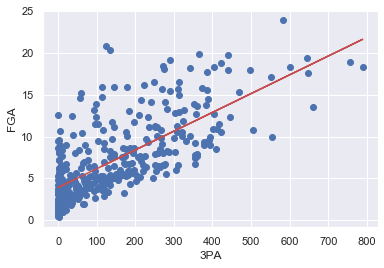

In [34]:
# scatter plots of 2PA against FGA
plt.scatter(train_df["3PA"], train_df["FGA"])
plt.xlabel("3PA")
plt.ylabel("FGA")
Linear_model.fit(train_df[["3PA"]], train_df[["FGA"]])
TWFPA_predict = Linear_model.predict(train_df[["3PA"]])
plt.plot(train_df["3PA"], TWFPA_predict, color="r")
print('R-squared:', Linear_model.score(train_df[["3PA"]], train_df[["FGA"]]))
print("VIF value:", 1/(1-Linear_model.score(train_df[["3PA"]], train_df[["FGA"]]))) #check for collinearity of the variables since it's smaller than 4 there is no problem 

## Machine Learning Models

Now that we have done our initial analyses, we can choose features to use in the model. We will make a fair amount of models using different algorithms and compare them to see which is best.

From our exploratory analyses and visualizations, it appears that some of our features are more important than others. To avoid overfitting and make our model as efficient as possible, we will use the following features in our final model:
* MP: minutes played
* PER: player efficiency rating
* FGA: field goal attempts
* 3PA: 3-point attempts

In [35]:
x_train = train_df[['MP','FGA', 'PER','3PA']]
y_train = train_df[['PTS']]

x_test = test_df[['MP', 'FGA', 'PER', '3PA']]
y_test = test_df[['PTS']]

### Linear Regression

In [36]:
# Fit linear regression model
# Linear regression models have no hyperparameters
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

# Predict
lin_y_pred = lin_reg.predict(x_test)

# MSE
lr_mse = MSE(y_test, lin_y_pred)
print('MSE:', lr_mse)

# r-squared value
lr_rsquared = r2_score(y_test, lin_y_pred)
print('R^2:', lr_rsquared)

# Display results
lr_df = pd.DataFrame({'Actual': np.array(y_test['PTS']), 'Predicted': lin_y_pred.flatten()}, 
                     index=test_df['Player'])

lr_df.round(1).head()



MSE: 1.0084119370902884
R^2: 0.959807209249739


,Actual,Predicted
Player,,
Lamar Patterson,1.8,1.3
Ryan Kelly,1.6,1.4
Troy Williams,6.2,6.1
Mike Conley,20.5,19.5
DeAndre Jordan,12.7,9.9


### Ridge Regression

In [37]:
# Ridge regression is least squares with l2 regularization.
ridge_params = {'alpha': np.arange(200, 500, 20)}
ridge = GridSearchCV(Ridge(), param_grid=ridge_params)
ridge.fit(x_train, y_train).best_estimator_

# Predict
ridge_predict = ridge.predict(x_test)

# MSE
ridge_mse = MSE(y_test, ridge_predict)
print('MSE:', ridge_mse)

# r squared value
ridge_rsquared = r2_score(y_test, ridge_predict)
print('R^2:', ridge_rsquared)

# Display results
lr1_df=pd.DataFrame({"Actual": np.array(y_test["PTS"]), "Predicted": ridge_predict.flatten()}, index=test_df['Player'])

lr1_df.round(1).head()


MSE: 0.9666438981183892
R^2: 0.9614719793587584


,Actual,Predicted
Player,,
Lamar Patterson,1.8,0.8
Ryan Kelly,1.6,1.3
Troy Williams,6.2,6.1
Mike Conley,20.5,19.5
DeAndre Jordan,12.7,10.5


### Decision Tree Regression

In [38]:
# Fit decision tree regression model
dt_params = {'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
dt_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=dt_params)
dt_reg.fit(x_train, y_train).best_estimator_

# Predict
dt_y_pred = dt_reg.predict(x_test)

# MSE
dt_mse = MSE(y_test, dt_y_pred)
print('MSE:', dt_mse)

# r-squared value
dt_rsquared = r2_score(y_test, dt_y_pred)
print('R^2:', dt_rsquared)

MSE: 1.5563341842215526
R^2: 0.9379683917820438


In [39]:
# Display results
dt_df = pd.DataFrame({'Actual': np.array(y_test['PTS']), 'Predicted': dt_y_pred.flatten()}, 
                     index=test_df['Player'])

dt_df.round(1).head()

,Actual,Predicted
Player,,
Lamar Patterson,1.8,2.0
Ryan Kelly,1.6,1.6
Troy Williams,6.2,5.6
Mike Conley,20.5,18.5
DeAndre Jordan,12.7,8.3


### Random Forest Regression

In [52]:
# Fit random forest regression model
rf_params = {
    'max_depth': [80, 90, 100, 110],
    'n_estimators': np.arange(10, 81, 5)}
rf_reg = GridSearchCV(RandomForestRegressor(), param_grid=rf_params)
rf_reg.fit(x_train, y_train.values.ravel()).best_estimator_

# Predict
rf_y_pred = rf_reg.predict(x_test)

# MSE
rf_mse = MSE(y_test, rf_y_pred)
print('MSE:', rf_mse)

# r-squared value
rf_rsquared = r2_score(y_test, rf_y_pred)
print('R^2:', rf_rsquared)

MSE: 0.9060881525772517
R^2: 0.963885580705331


In [53]:
# Display results
rf_df = pd.DataFrame({'Actual': np.array(y_test['PTS']), 'Predicted': rf_y_pred.flatten()}, 
                     index=test_df['Player'])

rf_df.round(1).head()

,Actual,Predicted
Player,,
Lamar Patterson,1.8,2.4
Ryan Kelly,1.6,1.7
Troy Williams,6.2,6.1
Mike Conley,20.5,19.0
DeAndre Jordan,12.7,9.1


## Model Results & Conclusions

In [62]:
scores_df = pd.DataFrame(data=[('Linear', lr_mse, np.sqrt(lr_mse), lr_rsquared), 
                               ('Ridge', ridge_mse, np.sqrt(ridge_mse), ridge_rsquared),
                               ('Decision Tree', dt_mse, np.sqrt(dt_mse), dt_rsquared),
                               ('Random Forest', rf_mse, np.sqrt(rf_mse), rf_rsquared)],
                         columns=('Regression Model', 'MSE', 'RMSE', 'R^2'))
scores_df.round(3)

,Regression Model,MSE,RMSE,R^2
0,Linear,1.008,1.004,0.960
1,Ridge,0.967,0.983,0.961
2,Decision Tree,1.556,1.248,0.938
3,Random Forest,0.906,0.952,0.964


As we want to use MSE as our main measure of accuracy, we can see that the random forest regressor did considerably better than the other models. The R<sup>2</sup> value of the random forest regressor is also on par with the others.

The RMSE of 0.952 for the random forest regressor is quite good. The average PPG for all players in the NBA was roughly 8.5, which means we are, on average, just under 90% accurate in predicting PPG. Due to the wide range of PPG in the NBA our accuracy will be, generally, better for those who score more points and worse for those who score less points.

## Thoughts for the Future/Reflections

In hindsight, we have come to recognize certain flaws and strengths of our model and procedures. This being said, all of us are new to the world of machine learning and data science, and indeed have found a sense of gratification and fulfillment with the progress we have made thus far. While we are aptly happy with our results, we believe it is of importance to disclose our conclusions about our methods to improve future iterations of the model and how we should approach model construction in times to come.

### Feature Selection

Admittedly, there was not a very analytical approach to feature selection beyond knowledge of the game of basketball, simple correlation modeling, and supposedly rational thinking to identify prudent choices for variables. While our decisions for the features our model used were based on our exploration of correlations, we did not employ rigorous computational testing procedures to determine the very best features, nor did we attempt any feature engineering of our own.

For example, we determined it rational that a player's defense statistics were likely to be of little use to our model. While the correlation visualizations appear to back up this claim, perhaps a more meticulous analysis of these such features would show them to be usefull.

While categorical variables did not appear to have a great impact on a player's points per game average, if someone were to find a need to utilize a feature such as a player's position, one-hot encoding them into the dataset would be useful.

Lastly, and perhaps most importantly, we did not check for collinearity between our features. Doing so could improve our model, maybe significantly.

### Model Selection

Our selection of regression models was by no means exhaustive. All of us being relatively new to machine learning, we opted for the most popular and widely used models for our project. This being said, our accuracy was indeed quite good, and we are nonetheless very satisfied with the results of our project.

In the future, perhaps regression models such as polynomial, lasso, or elastic net regression could prove useful.

### Model Tuning

This was likely the most technically advanced part of the project. The methods and implementations of hyperparameter tuning definitely appeared to be complex and highly mathematical. Given this, we believe that the most nuanced aspect was defining parameter grids for GridSearchCV. Seeing that none of us have a complete understanding of the mathematics behind each model, we more or less used trial and error to determine which ranges of parameters should be put into the parameter grid for GridSearchCV to use.

Nevertheless, hyperparameter tuning significantly improved the performance of each model. MSE consistently decreased by 10%-20%. However, it is likely that further tuning would result in even greater accuracy.